In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from scipy.io import savemat, loadmat
import matlab.engine # to run Cheng's code
import time
# import os

# add the path to my packages to system paths so they can be imported
import sys
sys.path.append('/home/yasamanparhizkar/Documents/yorku/01_thesis/code/my_packages')
# sys.path.append('F:\MAScThesis\code\my_packages')
# sys.path.append('/home/yasamanparhizkar/Documents/thesis/code/my_packages')

# import compare_with_benchmark as bn
import my_simgraph_06 as sg

# Generate the toy dataset

Generate two clusters of 2D vectors far enough from each other to be easily separable and both Gaussian distributed.

In [2]:
# if the number of data points in one set is odd, the -1 cluster is favored; i.e. there is one extra point in the -1 cluster
train_num = 210
val_num = 100
error_train_num = 30
error_val_num = 15

cpos_center = (10,5)
cpos_scale = (1, 2)
cneg_center = (10, 10)
cneg_scale = (2, 2)

# generate the training data
train_des = np.zeros((train_num, 2))
rng = np.random.default_rng(seed=0)
train_des[:train_num//2,0]=  rng.normal(loc=cpos_center[0], scale=cpos_scale[0], size=(train_num//2,)) # first dimension of datapoints for 1 cluster
train_des[:train_num//2,1]=  rng.normal(loc=cpos_center[1], scale=cpos_scale[1], size=(train_num//2,)) # second dimension of datapoints for 1 cluster
train_des[train_num//2:,0]=  rng.normal(loc=cneg_center[0], scale=cneg_scale[0], size=(np.ceil(train_num/2).astype(int),)) # first dimension of datapoints for -1 cluster
train_des[train_num//2:,1]=  rng.normal(loc=cneg_center[1], scale=cneg_scale[1], size=(np.ceil(train_num/2).astype(int),)) # second dimension of datapoints for -1 cluster
train_lbls = np.append(np.ones(train_num//2), -1 * np.ones(np.ceil(train_num/2).astype(int)))

# generate the validation data
val_des = np.zeros((val_num, 2))
rng = np.random.default_rng(seed=0)
val_des[:val_num//2,0]=  rng.normal(loc=cpos_center[0], scale=cpos_scale[0], size=(val_num//2,)) # first dimension of datapoints for 1 cluster
val_des[:val_num//2,1]=  rng.normal(loc=cpos_center[1], scale=cpos_scale[1], size=(val_num//2,)) # second dimension of datapoints for 1 cluster
val_des[val_num//2:,0]=  rng.normal(loc=cneg_center[0], scale=cneg_scale[0], size=(np.ceil(val_num/2).astype(int),)) # first dimension of datapoints for -1 cluster
val_des[val_num//2:,1]=  rng.normal(loc=cneg_center[1], scale=cneg_scale[1], size=(np.ceil(val_num/2).astype(int),)) # second dimension of datapoints for -1 cluster
val_lbls = np.append(np.ones(val_num//2), -1 * np.ones(np.ceil(val_num/2).astype(int)))

# # error train
# cpos_center = (10,10)
# cpos_scale = (5, 4)
# train_des[:error_train_num,0]=  rng.normal(loc=cpos_center[0], scale=cpos_scale[0], size=(error_train_num,)) # first dimension of datapoints for 1 cluster
# train_des[:error_train_num,1]=  rng.normal(loc=cpos_center[1], scale=cpos_scale[1], size=(error_train_num,)) # second dimension of datapoints for 1 cluster

# # error val
# val_des[:error_val_num,0]=  rng.normal(loc=cpos_center[0], scale=cpos_scale[0], size=(error_val_num,)) # first dimension of datapoints for 1 cluster
# val_des[:error_val_num,1]=  rng.normal(loc=cpos_center[1], scale=cpos_scale[1], size=(error_val_num,)) # second dimension of datapoints for 1 cluster

Text(0.5, 1.0, 'Validation Dataset')

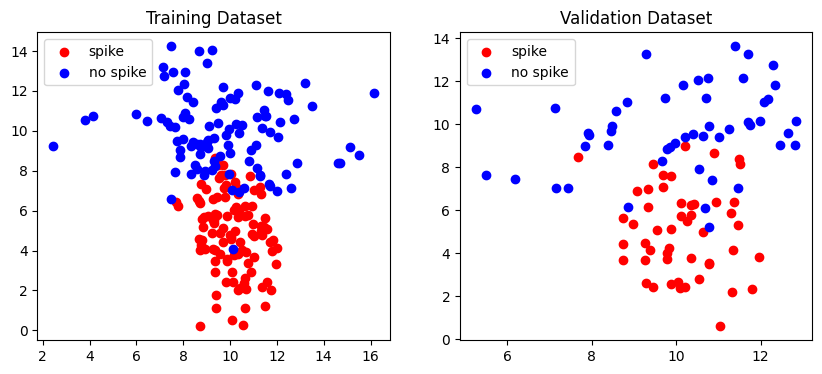

In [3]:
# visualize the datasets
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(train_des[:train_num//2,0], train_des[:train_num//2,1], color='r')
plt.scatter(train_des[train_num//2:,0], train_des[train_num//2:,1], color='b')
plt.legend(['spike', 'no spike'])
plt.title('Training Dataset')

plt.subplot(1,2,2)
plt.scatter(val_des[:val_num//2,0], val_des[:val_num//2,1], color='r')
plt.scatter(val_des[val_num//2:,0], val_des[val_num//2:,1], color='b')
plt.legend(['spike', 'no spike'])
plt.title('Validation Dataset')

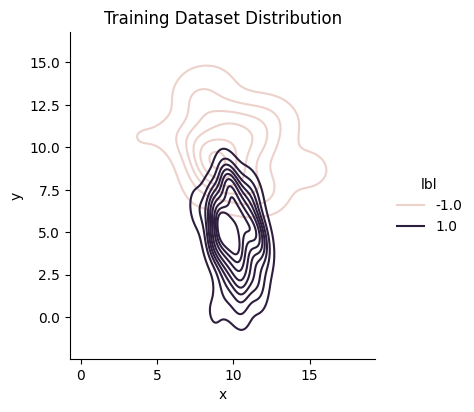

In [4]:
train_dataframe = pd.DataFrame(np.append(train_des, train_lbls.reshape((-1, 1)), axis=1), columns=['x', 'y', 'lbl'])
val_dataframe = pd.DataFrame(np.append(val_des, val_lbls.reshape((-1, 1)), axis=1), columns=['x', 'y', 'lbl'])


g = sns.displot(train_dataframe, x='x', y='y', hue='lbl', kind='kde', height=4)
g.set(title='Training Dataset Distribution')

# g = sns.displot(val_dataframe, x='x', y='y', hue='lbl', kind='kde', height=4)
# g.set(title='Validation Dataset Distribution')

In [5]:
# save the dataset on disc
data_path = '../../data/fe_exp/cheng_snap_2/'
savemat(data_path+'data.mat', {'train_des': train_des, 'train_lbls': train_lbls})

# Train the logistic regression model

In [6]:
# instantiate the model
lgrg = LogisticRegression(penalty='none')

In [7]:
print('Parameters used for fitting: \n', lgrg.get_params())

Parameters used for fitting: 
 {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'none', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [8]:
# train the model  
lgrg = lgrg.fit(train_des, train_lbls)

## Analyze the optimized parameters

In [9]:
# print optimized parameters
print('classes = ', lgrg.classes_)
print('decision boundary coefficients = ', lgrg.coef_)
print('decision boundary bias = ', lgrg.intercept_)
print('number of features seen during fit = ', lgrg.n_features_in_)
print('number of iterations done during fit = ', lgrg.n_iter_)

classes =  [-1.  1.]
decision boundary coefficients =  [[-0.22104645 -1.83410891]]
decision boundary bias =  [15.86288518]
number of features seen during fit =  2
number of iterations done during fit =  [22]


In [10]:
# compute confidence scores - positive means +1 while negative means -1
print('a(x) for all x\'s = \n', lgrg.decision_function(val_des))

a(x) for all x's = 
 [  3.1431347    8.94345337   4.35665169   2.05059526   9.32627442
   2.95255303   2.61679787   1.7192909    8.98103692   7.18886221
   6.22058828   8.76382937  -1.38456434   6.34934781   3.55054805
   5.59224164  -1.20634081  -0.29157857   2.06761127  12.33438646
   4.31943464   1.67191435   0.94616529   6.6707937   -2.40136732
   9.30472345   7.07285287   1.2556532    4.40311178  -2.9120094
   4.01351917   6.85080748   5.90205742   8.36488576   9.12123564
   2.09083557   2.49455982  -0.23819699   7.07663954  -2.0442556
   5.81438879  -1.62804387   5.77192789   7.00708293   3.50715199
   0.76767305   3.56896762   6.19641524   9.00351719   9.33225853
  -3.85164252  -5.43241934  -1.49949526  -2.34062493  -5.0323284
   1.32606435  -5.4764046   -4.5741199    0.65558151   3.93776084
  -6.31351615  -3.64537715  -2.71101503  -3.91175516 -11.65878636
  -4.17071776  -5.63461283   0.44523785 -11.10447519  -8.56919232
  -8.95060511  -5.2367036   -8.08457728  -5.41861565  -6.8

In [11]:
lgrg.predict_log_proba(val_des)

array([[-3.18537713e+00, -4.22424235e-02],
       [-8.94358395e+00, -1.30580761e-04],
       [-4.36939144e+00, -1.27397490e-02],
       [-2.17162484e+00, -1.21029578e-01],
       [-9.32636347e+00, -8.90494307e-05],
       [-3.00344218e+00, -5.08891518e-02],
       [-2.68729022e+00, -7.04923502e-02],
       [-1.88412135e+00, -1.64830449e-01],
       [-8.98116269e+00, -1.25764455e-04],
       [-7.18961687e+00, -7.54662774e-04],
       [-6.22257438e+00, -1.98610173e-03],
       [-8.76398564e+00, -1.56272778e-04],
       [-2.23489796e-01, -1.60805413e+00],
       [-6.35109417e+00, -1.74636094e-03],
       [-3.57885257e+00, -2.83045222e-02],
       [-5.59596137e+00, -3.71973786e-03],
       [-2.61818300e-01, -1.46815911e+00],
       [-5.57947721e-01, -8.49526287e-01],
       [-2.18671571e+00, -1.19104443e-01],
       [-1.23343909e+01, -4.39787689e-06],
       [-4.33265428e+00, -1.32196392e-02],
       [-1.84409048e+00, -1.72176133e-01],
       [-1.27419262e+00, -3.28027329e-01],
       [-6.

[Text(0.5, 1.0, 'Logistic Regression Decision Boundary on Train Data')]

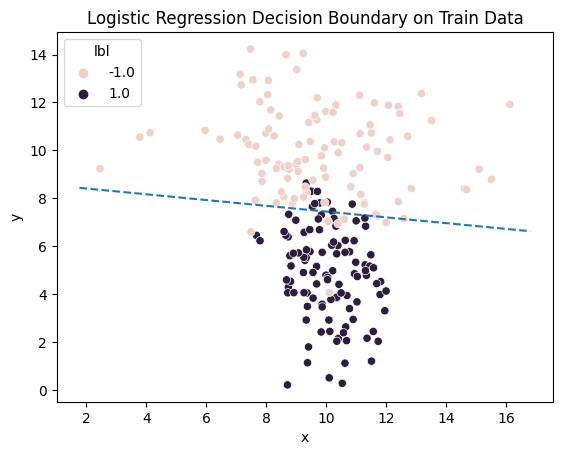

In [12]:
# draw a scatterplot of train data
g = sns.scatterplot(x=train_dataframe.x, y=train_dataframe.y, hue=train_dataframe.lbl)

# draw the optimized decision boundary
slope = -lgrg.coef_[0,0] / lgrg.coef_[0,1]
intercept = -lgrg.intercept_[0] / lgrg.coef_[0,1]
decision_x = np.array(g.get_xlim())
decision_y = intercept + slope * decision_x
[y_limlo, y_limup] = np.array(g.get_ylim())
if decision_y[0] > y_limup:
    decision_y[0] = y_limup
    decision_x[1] = 1/slope * decision_y[0] - intercept / slope
if decision_y[0] < y_limlo:
    decision_y[0] = y_limlo
    decision_x[1] = 1/slope * decision_y[0] - intercept / slope
if decision_y[1] > y_limup:
    decision_y[1] = y_limup
    decision_x[1] = 1/slope * decision_y[1] - intercept / slope
if decision_y[1] < y_limlo:
    decision_y[1] = y_limlo
    decision_x[1] = 1/slope * decision_y[1] - intercept / slope
g.plot(decision_x, decision_y, '--')
g.set(title='Logistic Regression Decision Boundary on Train Data')

## Validate the logistic regression model

In [13]:
# validate the model
val_loc = np.arange(val_num)
val_spikes = val_loc[val_lbls > 0]
preds_lgrg = lgrg.predict(val_des)
val_acc_lgrg = lgrg.score(val_des, val_lbls)

est_spikes_lgrg = val_loc[preds_lgrg > 0]
if sum(val_lbls==1) == 0:
    missed_lgrg = 0
else:
    missed_lgrg = sum(np.logical_and(val_lbls==1, preds_lgrg < 0))/sum(val_lbls==1)
if sum(val_lbls==-1) == 0:
    false_alarm_lgrg = 0
else:
    false_alarm_lgrg = sum(np.logical_and(val_lbls==-1, preds_lgrg > 0))/sum(val_lbls==-1)

print('Predicted labels WITH threshold =\n', preds_lgrg)
print('Validation accuracy =\n', val_acc_lgrg)
print('Estimated spike time bins: ', est_spikes_lgrg)
print('Real spike time bins: ', val_spikes)
print('Missed spikes (/all spikes): {:.2f}%'.format(missed_lgrg*100))
print('False spikes (/all no-spike bins): {:.2f}%'.format(false_alarm_lgrg*100))

Predicted labels WITH threshold =
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.
  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.
  1. -1.  1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1.
 -1.  1. -1. -1.  1.  1. -1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1. -1.
 -1. -1. -1. -1.  1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  1. -1. -1. -1. -1. -1.  1. -1. -1. -1.]
Validation accuracy =
 0.84
Estimated spike time bins:  [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 18 19 20 21 22 23 25 26 27
 28 30 31 32 33 34 35 36 38 40 42 43 44 45 46 47 48 49 55 58 59 67 76 78
 90 96]
Real spike time bins:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
Missed spikes (/all spikes): 16.00%
False spikes (/all no-spike bins): 16.00%


# Train the similarity graph model with GDPA

In [14]:
# import importlib
# importlib.reload(sg)

## Run Cheng's code

In [16]:
eng = matlab.engine.start_matlab()
eng.cd(r'/home/yasamanparhizkar/Documents/yorku/01_thesis/code/15_cheng', nargout=0)
M_gdpa = eng.gdpa_fit('test')
M_gdpa = np.array(M_gdpa)
eng.quit()

starting SGML.
initial objective value = -563684.7926
converged objective value = -1137362.3904
minimal eigenvalue of M = 1e-05
done with SGML.


In [18]:
print('Optimized M computed by Chengs code:\n', M_gdpa)

Optimized M computed by Chengs code:
 [[1.00000344e-05 0.00000000e+00]
 [0.00000000e+00 1.99999000e+00]]


## Analyze the optimized parameters

M_gdpa = 
 [[1.00000344e-05 0.00000000e+00]
 [0.00000000e+00 1.99999000e+00]]


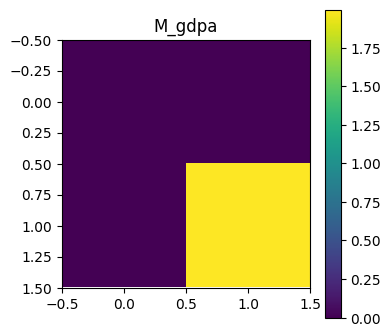

In [19]:
# display the optimized B
print('M_gdpa = \n', M_gdpa)
sg.display_matrix(M_gdpa, 'M_gdpa')

## Validate the similarity graph

In [20]:
# graph construction and penalty term parameters
sg_params = {'mu': 30, 'Dt': None, 'Dv': 0, 'Dvt': 2000, \
             'cnstr_method_tt': 'time', 'cnstr_method_vv': 'time', 'cnstr_method_vt': 'time',\
             'train_t': np.arange(len(train_lbls)), 'val_t': np.arange(len(val_lbls)), \
             'edges_tt':None, 'edges_vv':None, 'edges_vt':None, }

val_acc_gdpa, y_est_gdpa, t_gdpa = sg.get_acc(M_gdpa, train_des, train_lbls, val_des, val_lbls, sg_params, seed=0, show_edges=False)
print('Elapsed time = {} ms'.format(t_gdpa*1000))

Elapsed time = 91.16554260253906 ms


In [21]:
# print results
print('val acc = {:.2f}%'.format(val_acc_gdpa*100))
print('estimated val labels WITH threshold = ', 2*(y_est_gdpa>0).astype(np.int32)-1)
print('Estimated validation labels withOUT threshold:\n', y_est_gdpa)

val acc = 84.00%
estimated val labels WITH threshold =  [ 1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1  1  1  1
 -1  1  1  1  1 -1  1  1  1  1  1  1  1 -1  1 -1  1 -1  1  1  1  1  1  1
  1  1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1
 -1 -1 -1 -1  1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1
  1 -1 -1 -1]
Estimated validation labels withOUT threshold:
 [ 0.96894903  0.99796839  0.9857487   0.7530367   0.99925208  0.95729821
  0.94342726  0.70188862  0.99730096  0.92771243  0.92155146  0.99682225
 -0.62568268  0.91853336  0.97572746  0.94681254 -0.4538424  -0.12811815
  0.78086424  0.99994302  0.98999931  0.71828835  0.27271782  0.92293404
 -0.71211355  0.99950485  0.9276906   0.36313837  0.98982478 -0.86898735
  0.99169825  0.92443149  0.92768388  0.99272577  0.99914206  0.78428167
  0.83702242 -0.09438684  0.94184579 -0.57137859  0.94165373 -0.44348753
  0.92184523  0.93859971  0.98764793  0.23787801  0.99242447  0.92042135
  0.99

In [22]:
# comparing estimated and real spike locations
val_loc = np.arange(val_num)
val_spikes = val_loc[val_lbls==1]
est_spikes_gdpa = val_loc[y_est_gdpa > 0]

if sum(val_lbls==1) == 0:
    missed_gdpa = 0
else:
    missed_gdpa = sum(np.logical_and(val_lbls==1, y_est_gdpa < 0))/sum(val_lbls==1)

if sum(val_lbls==-1) == 0:
    false_alarm_gdpa = 0
else:
    false_alarm_gdpa = sum(np.logical_and(val_lbls==-1, y_est_gdpa > 0))/sum(val_lbls==-1)

nospk_per = np.sum(val_lbls==-1)/val_num
min_acc = max(nospk_per, 1-nospk_per)

print('Estimated spike time bins: ', est_spikes_gdpa)
print('Real spike time bins: ', val_spikes)
print('{:.2f}% of validation points have label {} (= min accuracy)'.format(min_acc*100, -1 if nospk_per > 50 else 1))
print('Missed spikes (/all spikes): {:.2f}%'.format(missed_gdpa*100))
print('False spikes (/all no-spike bins): {:.2f}%'.format(false_alarm_gdpa*100))

Estimated spike time bins:  [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 18 19 20 21 22 23 25 26 27
 28 30 31 32 33 34 35 36 38 40 42 43 44 45 46 47 48 49 55 59 67 76 78 90
 91 96]
Real spike time bins:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
50.00% of validation points have label 1 (= min accuracy)
Missed spikes (/all spikes): 16.00%
False spikes (/all no-spike bins): 16.00%


# Train the similarity graph model with factorization

In [23]:
# graph construction and penalty term parameters
sg_params = {'mu': 30, 'Dt': None, 'Dv': 0, 'Dvt': 2000, \
             'cnstr_method_tt': 'time', 'cnstr_method_vv': 'time', 'cnstr_method_vt': 'time',\
             'train_t': np.arange(len(train_lbls)), 'val_t': np.arange(len(val_lbls)), \
             'edges_tt':None, 'edges_vv':None, 'edges_vt':None, }

# gradient descent parameters
sg_opt_params = { 'epsilon0':1, 'epsilon_decay':0.5, 'epsilon_jump': 2, \
                  'num_its':10, 'check_freq':1, 'print_checks':True, 'Theta0':None, \
                  'force_all_its': True, 'threshold': 0.01}

time0 = time.time()
B_fact, sg_stats_fact = sg.fit_graph(dess=train_des, lbls=train_lbls, graph_params=sg_params, opt_params=sg_opt_params, seed=0)
print('Elapsed time = {} sec'.format(time.time()-time0))

Number of training datapoints: 210
Number of features for each point: 2
mu = 30
   0: eps = 9.77e-04;  train loss (E) = 33082.83
   1: eps = 1.95e-03;  train loss (E) = 25794.42
   2: eps = 3.91e-03;  train loss (E) = 15147.30
   3: eps = 7.81e-03;  train loss (E) = 4356.65
   4: eps = 1.56e-02;  train loss (E) = 634.52
   5: eps = 1.95e-03;  train loss (E) = 411.84
   6: eps = 3.91e-03;  train loss (E) = 388.39
   7: eps = 7.81e-03;  train loss (E) = 387.03
   8: eps = 7.81e-03;  train loss (E) = 386.93
   9: eps = 7.81e-03;  train loss (E) = 386.54
Elapsed time = 2.3923707008361816 sec


## Display learned metric matrix

M_fact - Coordinates of elements with higher values than 0.94
[(0, 0), (1, 1)]


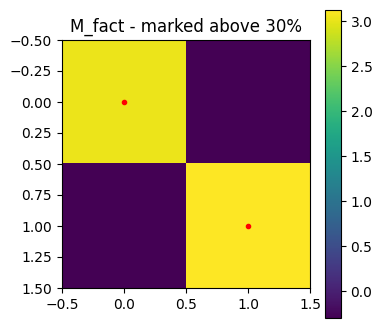

In [24]:
# display learned M
M_fact = B_fact.T @ B_fact

sg.display_matrix(M_fact, None)

# mark elements with high values
thresh = 30
lim = (thresh/100) * np.max(M_fact) # marker threshold
f_sz = M_fact.shape[0]
xloc = np.broadcast_to(np.arange(f_sz), (f_sz, f_sz))
yloc = xloc.T
plt.plot(xloc[M_fact > lim],yloc[M_fact > lim], marker='o', markersize=3, color='r', linestyle='')
plt.title('M_fact - marked above {}%'.format(thresh))
print('M_fact - Coordinates of elements with higher values than {:.2f}'.format(lim))
print(list(zip(xloc[M_fact > lim],yloc[M_fact > lim])))

## Validate the similarity graph

In [25]:
val_acc_fact, y_est_fact, t_fact = sg.get_acc(M_fact, train_des, train_lbls, val_des, val_lbls, sg_params, seed=0, show_edges=False)

In [26]:
print('val acc = {:.2f}%'.format(val_acc_fact*100))
print('elapsed time = {:.2f} ms'.format(t_fact*1000))
print('estimated val labels = ', 2*(y_est_fact>0).astype(np.int32)-1)

val acc = 87.00%
elapsed time = 93.65 ms
estimated val labels =  [ 1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1
 -1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1 -1  1 -1  1  1  1  1  1  1
  1  1 -1 -1  1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1  1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1
 -1 -1 -1 -1]


In [27]:
# comparing estimated and real spike locations
est_spikes_fact = val_loc[y_est_fact > 0]

if sum(val_lbls==1) == 0:
    missed_fact = 0
else:
    missed_fact = sum(np.logical_and(val_lbls==1, y_est_fact < 0))/sum(val_lbls==1)

if sum(val_lbls==-1) == 0:
    false_alarm_fact = 0
else:
    false_alarm_fact = sum(np.logical_and(val_lbls==-1, y_est_fact > 0))/sum(val_lbls==-1)

nospk_per = np.sum(val_lbls==-1)/val_num
min_acc = max(nospk_per, 1-nospk_per)

print('Estimated spike time bins: ', est_spikes_fact)
print('Real spike time bins: ', val_spikes)
print('{:.2f}% of validation points have label {} (= min accuracy)'.format(min_acc*100, -1 if nospk_per > 50 else 1))
print('Missed spikes (/all spikes): {:.2f}%'.format(missed_fact*100))
print('False spikes (/all no-spike bins): {:.2f}%'.format(false_alarm_fact*100))

Estimated spike time bins:  [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 17 18 19 20 21 22 23 25 26
 27 28 30 31 32 33 34 35 36 37 38 40 42 43 44 45 46 47 48 49 52 59 67 78
 81 90 91]
Real spike time bins:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
50.00% of validation points have label 1 (= min accuracy)
Missed spikes (/all spikes): 12.00%
False spikes (/all no-spike bins): 14.00%


## Comparison of all three methods

In [28]:
print('GDPA val acc = {:.2f}%'.format(val_acc_gdpa*100))
print('Factorization val acc = {:.2f}%'.format(val_acc_fact*100))
print('LogReg val acc = {:.2f}%'.format(val_acc_lgrg*100))

GDPA val acc = 84.00%
Factorization val acc = 87.00%
LogReg val acc = 84.00%


In [29]:
print('Real spike time bins: ', val_spikes)
print('GDPA Estimated spike time bins: ', est_spikes_gdpa)
print('Factorization Estimated spike time bins: ', est_spikes_fact)
print('LogReg Estimated spike time bins: ', est_spikes_lgrg)

Real spike time bins:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
GDPA Estimated spike time bins:  [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 18 19 20 21 22 23 25 26 27
 28 30 31 32 33 34 35 36 38 40 42 43 44 45 46 47 48 49 55 59 67 76 78 90
 91 96]
Factorization Estimated spike time bins:  [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 17 18 19 20 21 22 23 25 26
 27 28 30 31 32 33 34 35 36 37 38 40 42 43 44 45 46 47 48 49 52 59 67 78
 81 90 91]
LogReg Estimated spike time bins:  [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 18 19 20 21 22 23 25 26 27
 28 30 31 32 33 34 35 36 38 40 42 43 44 45 46 47 48 49 55 58 59 67 76 78
 90 96]


# Substitute factorization M into GDPA objective

In [30]:
gamma = 1.0
eng = matlab.engine.start_matlab()
eng.cd(r'/home/yasamanparhizkar/Documents/yorku/01_thesis/code/15_cheng/SGML-master/SGML_in_Matlab/', nargout=0)
V = eng.get_objective_variables_ready(train_des, train_lbls.reshape((train_num,1)), train_des.shape[0], train_des.shape[1], gamma)
eng.quit()
V = np.array(V)

In [32]:
loss_gdpa = np.sum(M_gdpa * V.T)
loss_fact = np.sum(M_fact * V.T)

print('GDPA loss with GDPA metric: ', loss_gdpa)
print('GDPA loss with Factorization metric: ', loss_gdpa)

GDPA loss with GDPA metric:  -1137362.3904101357
GDPA loss with Factorization metric:  -1137362.3904101357
